In [1]:
import cv2
from segment_anything import build_sam, SamAutomaticMaskGenerator, sam_model_registry
from PIL import Image, ImageDraw
import clip
import torch
import numpy as np

/ext3/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
sam_checkpoint = "/scratch/sg7729/DL_project/SLIP/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

In [60]:
# import os
# os.environ['KAGGLE_USERNAME'] = 'saaketh1129'
# os.environ['KAGGLE_KEY'] = '963a37f682f1e695d5f9aa5da331d2b9'
# ### For Flickr 8k
# !kaggle datasets download -d kvpratama/pokemon-images-dataset
# !unzip pokemon-images-dataset.zip

In [118]:
# %%bash
!python /scratch/sg7729/DL_project/makes_image_pairs.py

['golduck.png']
['cranidos.png']
['xurkitree.png']
['hattrem.png']
['volcarona.png']
['nidorina.png']
['manaphy.png']
['mimikyu-disguised.png']
['carracosta.png']
['piloswine.png']
['munna.png']
['machamp.png']
['cufant.png']
['klinklang.png']
['suicune.png']
['brionne.png']
['tyrantrum.png']
['exeggutor.png']
['lopunny.png']
['barraskewda.png']
['regidrago.png']
['carbink.png']
['rufflet.png']
['clobbopus.png']
['lombre.png']
['charmander.png']
['bewear.png']
['shinx.png']
['toxel.png']
['seel.png']
['calyrex.png']
['spritzee.png']
['tyranitar.png']
['timburr.png']
['sigilyph.png']
['drifloon.png']
['linoone.png']
['fearow.png']
['grotle.png']
['gabite.png']


In [ ]:
# !unzip /scratch/sg7729/DL_project/SLIP/archive.zip

In [3]:
# Download the model weights to load them here
mask_generator = SamAutomaticMaskGenerator(
        model = sam,
        points_per_side = 16,
        pred_iou_thresh =  0.9,
        min_mask_region_area = 1,
        crop_overlap_ratio = 0.8 )

In [152]:
image_path = '/scratch/sg7729/DL_project/SLIP/pokemon_test2.jpeg'

In [153]:
image = cv2.imread(image_path)
# image.show()

In [154]:
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


In [155]:
masks = mask_generator.generate(image)

In [156]:
len(masks)

43

In [157]:
# from google.colab.patches import cv2_imshow as show
annotations = masks
# Load the image and annotation data
img_test = cv2.imread('/scratch/sg7729/DL_project/SLIP/pokemon_test2.jpeg')
# Draw rectangles around the objects in the img_test
for annotation in annotations:
    bbox = annotation['bbox']
    cv2.rectangle(img_test, (bbox[0], bbox[1]), (bbox[0]+bbox[2], bbox[1]+bbox[3]), (0, 255, 0), 2)

# Display the img_test with bounding boxes around the objects
# cv2.imshow('img', img_test)
# cv2.waitKey(0)

In [158]:
# masks = valid_annotations
def convert_box_xywh_to_xyxy(box):
    x1 = box[0]
    y1 = box[1]
    x2 = box[0] + box[2]
    y2 = box[1] + box[3]
    return [x1, y1, x2, y2]

In [159]:
def segment_image(image, segmentation_mask):
    image_array = np.array(image)
    segmented_image_array = np.zeros_like(image_array)
    segmented_image_array[segmentation_mask] = image_array[segmentation_mask]
    segmented_image = Image.fromarray(segmented_image_array)
    black_image = Image.new("RGB", image.size, (0, 0, 0))
    transparency_mask = np.zeros_like(segmentation_mask, dtype=np.uint8)
    transparency_mask[segmentation_mask] = 255
    transparency_mask_image = Image.fromarray(transparency_mask, mode='L')
    black_image.paste(segmented_image, mask=transparency_mask_image)
    return black_image

In [160]:
# Cut out all masks
image = Image.open(image_path)
cropped_boxes1 = []

for mask in masks:
    cropped_boxes1.append(segment_image(image, mask["segmentation"]).crop(convert_box_xywh_to_xyxy(mask["bbox"])))

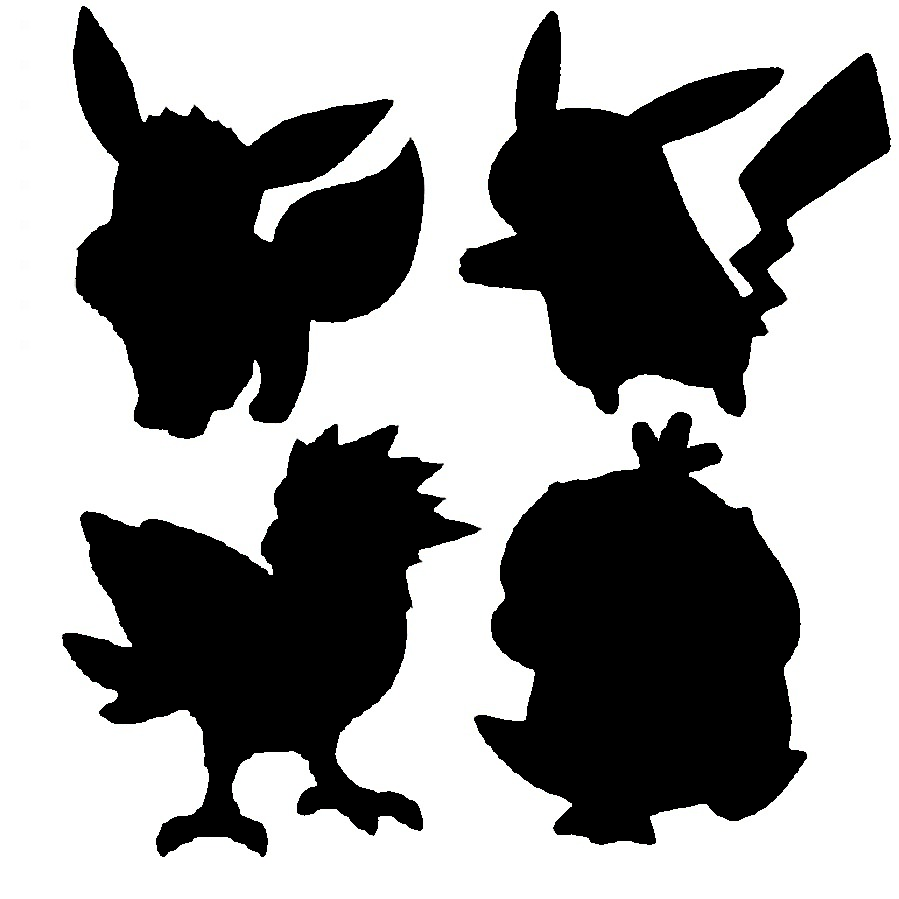

In [161]:
cropped_boxes1[0]

In [77]:
# for im in cropped_boxes:
#     im.show()

In [162]:
annotations =  masks
def filter_annotations(annotations):
    annotations.sort(key=lambda x: x['area'], reverse=True)
    to_remove = set()
    for i in range(0, len(annotations)):
        a = annotations[i]
        for j in range(i + 1, len(annotations)):
            b = annotations[j]
            if i != j and j not in to_remove:
                # check if 
                if b['area'] < a['area']:
                    if (a['segmentation'] & b['segmentation']).sum() / b['segmentation'].sum() > 0.8:
                        # print('area')
                        to_remove.add(j)
#                         print(i, j)
    print(to_remove)
    return [a for i, a in enumerate(annotations) if i not in to_remove]

In [163]:
new_annotaions = filter_annotations(annotations)
len(new_annotaions)
new_annotaions.pop(0)

{4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42}


{'segmentation': array([[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]]),
 'area': 466801,
 'bbox': [0, 0, 899, 899],
 'predicted_iou': 1.0390514135360718,
 'point_coords': [[534.375, 28.125]],
 'stability_score': 0.9694608449935913,
 'crop_box': [0, 0, 900, 900]}

In [165]:
# Cut out all masks
image = Image.open(image_path)
cropped_boxes = []

for mask in new_annotaions:
    cropped_boxes.append(segment_image(image, mask["segmentation"]).crop(convert_box_xywh_to_xyxy(mask["bbox"])))


In [166]:
len(new_annotaions)

4

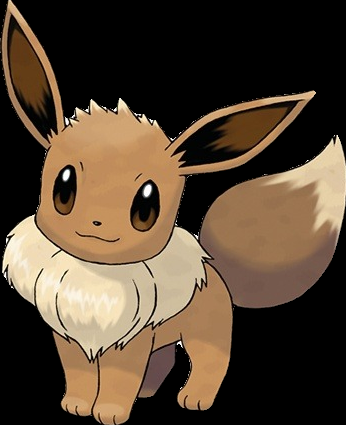

In [167]:
cropped_boxes[2]

In [168]:
# # Load CLIP
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import os
import cv2
import gc
import numpy as np
import pandas as pd
import itertools
from tqdm.autonotebook import tqdm
import albumentations as A
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
import timm
from transformers import DistilBertModel, DistilBertConfig, DistilBertTokenizer

In [169]:
class config:
    image_path = "/scratch/sg7729/DL_project/SLIP/Images"
    captions_path = "/scratch/sg7729/DL_project/SLIP/"
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    text_tokenizer = "distilbert-base-uncased"

In [170]:
class CLIPDataset(torch.utils.data.Dataset):
    def __init__(self, image_filenames, captions, tokenizer, transforms):
        """
        image_filenames and cpations must have the same length; so, if there are
        multiple captions for each image, the image_filenames must have repetitive
        file names 
        """

        self.image_filenames = image_filenames # one description per image
        self.captions = list(captions) # one description per image
        self.encoded_captions = tokenizer(
            list(captions), padding=True, truncation=True, max_length=200
        )
        self.transforms = transforms

    def __getitem__(self, idx):
        item = {
            key: torch.tensor(values[idx])
            for key, values in self.encoded_captions.items()
        }

#         image = cv2.imread(f"{config.image_path}/{self.image_filenames[idx]}")
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#         image = self.transforms(image=image)['image']
        item['image'] = [1]
        item['caption'] = self.captions[idx]

        return item


    def __len__(self):
        return len(self.captions)

In [95]:
class ImageEncoder(nn.Module):
    """
    Encode images to a fixed size vector
    """

    def __init__(
        self, model_name='resnet50', pretrained=True, trainable=True
    ):
        super().__init__()
        self.model = timm.create_model(
            model_name, pretrained, num_classes=0, global_pool="avg"
        )
        for p in self.model.parameters():
            p.requires_grad = trainable

    def forward(self, x):
        return self.model(x)

In [96]:
def make_train_valid_dfs():
    dataframe = pd.read_csv(f"{config.captions_path}/captions.csv")
    max_id = dataframe["id"].max() + 1
    image_ids = np.arange(0, max_id)
    np.random.seed(42)
    valid_ids = np.random.choice(
        image_ids, size=int(0.2 * len(image_ids)), replace=False
    )
    train_ids = [id_ for id_ in image_ids if id_ not in valid_ids]
    train_dataframe = dataframe[dataframe["id"].isin(train_ids)].reset_index(drop=True)
    valid_dataframe = dataframe[dataframe["id"].isin(valid_ids)].reset_index(drop=True)
    return train_dataframe, valid_dataframe


def build_loaders(dataframe, tokenizer, mode):
    transforms = A.Compose(
        [
            A.Resize(224, 224, always_apply=True),
            A.Normalize(max_pixel_value=255.0, always_apply=True),
        ]
    )
    dataset = CLIPDataset(
        dataframe["image"].values,
        dataframe["caption"].values,
        tokenizer=tokenizer,
        transforms=transforms,
    )
    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=32,
        num_workers=2,
        shuffle=True if mode == "train" else False,
    )
    return dataloader

class AvgMeter:
    def __init__(self, name="Metric"):
        self.name = name
        self.reset()

    def reset(self):
        self.avg, self.sum, self.count = [0] * 3

    def update(self, val, count=1):
        self.count += count
        self.sum += val * count
        self.avg = self.sum / self.count

    def __repr__(self):
        text = f"{self.name}: {self.avg:.4f}"
        return text

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]

In [97]:
# dataframe, _ = make_train_valid_dfs()
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
train_df, valid_df = make_train_valid_dfs()
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
train_loader = build_loaders(train_df, tokenizer, mode="train")
valid_loader = build_loaders(valid_df, tokenizer, mode="valid")


In [98]:
class TextEncoder(nn.Module):
    def __init__(self, model_name="distilbert-base-uncased", pretrained=True, trainable=True):
        super().__init__()
        if pretrained:
            self.model = DistilBertModel.from_pretrained(model_name)
        else:
            self.model = DistilBertModel(config=DistilBertConfig())
            
        for p in self.model.parameters():
            p.requires_grad = trainable

        # we are using the CLS token hidden representation as the sentence's embedding
        self.target_token_idx = 0

    def forward(self, input_ids, attention_mask):
        output = self.model(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = output.last_hidden_state
        return last_hidden_state[:, self.target_token_idx, :]

In [99]:
class ProjectionHead(nn.Module):
    def __init__(
        self,
        embedding_dim,
        projection_dim=128,
        dropout=0
    ):
        super().__init__()
        self.projection = nn.Linear(embedding_dim, projection_dim)
        self.gelu = nn.GELU()
        self.fc = nn.Linear(projection_dim, projection_dim)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(projection_dim)
    
    def forward(self, x):
        projected = self.projection(x)
        x = self.gelu(projected)
        x = self.fc(x)
        x = self.dropout(x)
        x = x + projected
        x = self.layer_norm(x)
        return x

In [100]:
class CLIPModel(nn.Module):
    def __init__(
        self,
        temperature=1,
        image_embedding=2048,
        text_embedding=768,
    ):
        super().__init__()
        self.image_encoder = ImageEncoder()
        self.text_encoder = TextEncoder()
        self.image_projection = ProjectionHead(embedding_dim=image_embedding)
        self.text_projection = ProjectionHead(embedding_dim=text_embedding)
        self.temperature = temperature

    def forward(self, batch):
        # Getting Image and Text Features
        image_features = self.image_encoder(batch["image"])
        text_features = self.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )
        # Getting Image and Text Embeddings (with same dimension)
        image_embeddings = self.image_projection(image_features)
        text_embeddings = self.text_projection(text_features)

        # Calculating the Loss
        batch_size = len(image_embeddings) 
        logits = (text_embeddings @ image_embeddings.T) / self.temperature
        images_similarity = image_embeddings @ image_embeddings.T
        texts_similarity = text_embeddings @ text_embeddings.T
        targets = F.softmax(
            (images_similarity + texts_similarity) / 2 * self.temperature, dim=-1
        )
        texts_loss = cross_entropy(logits, targets, reduction='none')
        images_loss = cross_entropy(logits.T, targets.T, reduction='none')
        loss =  (images_loss + texts_loss) / 2.0 # shape: (batch_size)
        return loss.mean()


def cross_entropy(preds, targets, reduction='none'):
    log_softmax = nn.LogSoftmax(dim=-1)
    loss = (-targets * log_softmax(preds)).sum(1)
    if reduction == "none":
        return loss
    elif reduction == "mean":
        return loss.mean()

In [101]:
def get_masks_embeddings(model, masks): 
    model.eval()
    # Apply transforms
    transforms = A.Compose(
        [
            A.Resize(224, 224, always_apply=True),
            A.Normalize(max_pixel_value=255.0, always_apply=True),
        ],
    )

    
    processed_masks = []
    
    for mask in masks:
#         print(mask)
        mask = np.array(mask)
#         print(mask.shape)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        mask = transforms(image=mask)['image']
        mask = np.transpose(mask, (2, 0, 1))
#         print(mask.shape)
        processed_masks.append(mask)
        
    processed_masks = torch.tensor(processed_masks)
    print(processed_masks.shape)

    mask_image_embeddings = []
    with torch.no_grad():
        image_features = model.image_encoder(processed_masks.to(device))
        image_embeddings = model.image_projection(image_features)
        mask_image_embeddings.append(image_embeddings)
    return torch.cat(mask_image_embeddings)

In [102]:
# def get_text_embeddings(model, masks): 
#     model.eval()
#     tokenizer = DistilBertTokenizer.from_pretrained(config.text_tokenizer)
#     valid_text_embeddings = []
#     with torch.no_grad():
# #         read from captions from CSV
#         captions = pd.read_csv('/scratch/sg7729/DL_project/SLIP/captions.csv')['caption'].tolist()
#         encoded = tokenizer(captions,  padding=True, truncation=True, max_length=64)
# #         encoded = torch.tensor(encoded)
# #         print(encoded.keys())
#         input_ids = torch.tensor(encoded['input_ids'])
#         attention_mask = torch.tensor(encoded['attention_mask'])
#         text_features = model.text_encoder(
#                   input_ids=input_ids.to(config.device), attention_mask=attention_mask.to(config.device)
#         )
#         text_embeddings = model.text_projection(text_features)
# #         valid_text_embeddings.append(text_embeddings)
  
#     return torch.cat(valid_text_embeddings)

In [171]:
def find_matching_masks(model, image_embeddings, query, n=9):
    tokenizer = DistilBertTokenizer.from_pretrained(config.text_tokenizer)
    encoded_query = tokenizer([query])
    batch = {
        key: torch.tensor(values).to(config.device)
        for key, values in encoded_query.items()
    }
    with torch.no_grad():
        text_features = model.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )
        text_embeddings = model.text_projection(text_features)
    
    image_embeddings_n = F.normalize(image_embeddings, p=2, dim=-1)
    text_embeddings_n = F.normalize(text_embeddings, p=2, dim=-1)
    dot_similarity = text_embeddings_n @ image_embeddings_n.T
    
    values, indices = torch.topk(dot_similarity.squeeze(0), 1)
    print(dot_similarity)
    return dot_similarity, values

In [172]:
# %%bash
# gdown https://drive.google.com/u/2/uc?id=1vg1pryTQa6LR1tKPi1rNXmSuneYh6Qnp&export=download

In [173]:
model = CLIPModel().to(device)
model.load_state_dict(torch.load('/scratch/sg7729/DL_project/SLIP/TrainL_Metric: 0.3710_ValidL_Metric: 0.7791_Epoch_99.pt'))

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<All keys matched successfully>

In [174]:
mask_image_embeddings = get_masks_embeddings(model, cropped_boxes)

torch.Size([4, 3, 224, 224])


In [141]:
# def find_matching_text(model, text_embeddings, query, captions, n=9):
#     with torch.no_grad():
#         query = torch.unsqueeze(query, 0)
#         image_features = model.image_encoder(query.to(config.device))
#         image_embeddings = model.image_projection(image_features)

#         image_embeddings_n = F.normalize(image_embeddings, p=2, dim=-1)
#         text_embeddings_n = F.normalize(text_embeddings, p=2, dim=-1)
#         dot_similarity = image_embeddings_n @ text_embeddings_n.T
#         values, indices = torch.topk(dot_similarity, n * 5)
#         print(values)
#         print(torch.argmax(values))
#         print(captions[torch.argmax(values)])

def find_matching_text(model, text_embeddings, query, captions, n=1):
  with torch.no_grad():
    query = torch.unsqueeze(query, 0)
    image_features = model.image_encoder(query.to(config.device))
    image_embeddings = model.image_projection(image_features)

  image_embeddings_n = F.normalize(image_embeddings, p=2, dim=-1)
  text_embeddings_n = F.normalize(text_embeddings, p=2, dim=-1)
  dot_similarity = image_embeddings_n @ text_embeddings_n.T
  values, indices = torch.topk(dot_similarity, n * 5)

  matches = [captions[idx] for idx in indices.cpu()[::5]][0]

  for i in range(n):
    print(matches[i])
  


In [183]:
scores, values = find_matching_masks(model, mask_image_embeddings, ' Spearow')

tensor([[0.7159, 0.8202, 0.7165, 0.7103]], device='cuda:0')


tensor([[0.7159, 0.8202, 0.7165, 0.7103]], device='cuda:0')
tensor([0.8202], device='cuda:0')


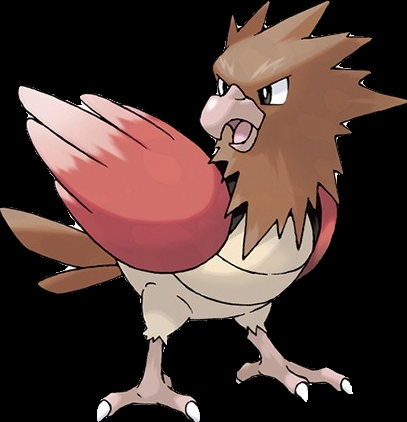

In [184]:
print(scores)
print(values)
max_idx = torch.argmax(scores)
cropped_boxes[max_idx]

In [185]:
# captions = pd.read_csv('/scratch/sg7729/DL_project/SLIP/captions.csv')['caption'].tolist()
processed_masks = []
transforms = A.Compose(
    [
        A.Resize(224, 224, always_apply=True),
        A.Normalize(max_pixel_value=255.0, always_apply=True),
    ],
)
for mask in cropped_boxes:
#         print(mask)
    mask = np.array(mask)
#         print(mask.shape)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
    mask = transforms(image=mask)['image']
    mask = np.transpose(mask, (2, 0, 1))
#         print(mask.shape)
    processed_masks.append(mask)

processed_masks = torch.tensor(processed_masks)

for m in processed_masks:
    find_matching_text(model, text_embeddings, query=m, captions=valid_df['caption'].values)

Psyduck
Spearow
Eevee
Pikachu


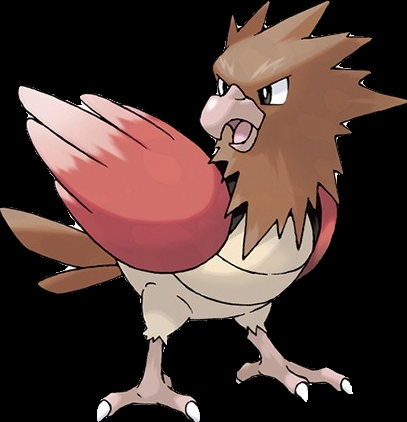

In [187]:
cropped_boxes[1]

In [92]:
# @torch.no_grad()
# def retriev(elements: list[Image.Image], search_text: str) -> int:
#     preprocessed_images = [preprocess(image).to(device) for image in elements]
#     tokenized_text = clip.tokenize([search_text]).to(device)
#     stacked_images = torch.stack(preprocessed_images)
#     image_features = model.encode_image(stacked_images)
#     text_features = model.encode_text(tokenized_text)
#     image_features /= image_features.norm(dim=-1, keepdim=True)
#     text_features /= text_features.norm(dim=-1, keepdim=True)
#     probs = 100. * image_features @ text_features.T
#     return probs[:, 0].softmax(dim=0)

In [51]:
def get_image_embeddings(model, valid_loader): 
    model.eval()
    
    valid_image_embeddings = []
    with torch.no_grad():
        for batch in tqdm(valid_loader):
            print(batch['image'].shape)
            image_features = model.image_encoder(batch["image"].to(config.device))
            image_embeddings = model.image_projection(image_features)
            valid_image_embeddings.append(image_embeddings)
    return torch.cat(valid_image_embeddings)



In [54]:
# image_embeddings = get_image_embeddings(model, valid_loader)
text_embeddings = get_text_embeddings(model, valid_loader, tokenizer)

100%|██████████| 67/67 [00:00<00:00, 67.04it/s] 


In [53]:
def get_text_embeddings(model, valid_loader, tokenizer):
  
  model.eval()
  
  valid_text_embeddings = []
  with torch.no_grad():
    for batch in tqdm(valid_loader):
      encoded = tokenizer(batch['caption'])
      text_features = model.text_encoder(
                  input_ids=batch["input_ids"].to(config.device), attention_mask=batch["attention_mask"].to(config.device)
      )
      text_embeddings = model.text_projection(text_features)
      valid_text_embeddings.append(text_embeddings)
  
  return torch.cat(valid_text_embeddings)